In [223]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer 
from sklearn.metrics import confusion_matrix, roc_auc_score
from bokeh.plotting import figure, output_file, show
from matplotlib import pyplot as plt
pd.options.display.max_columns = 100
import seaborn as sns
sns.set(style="whitegrid")


%matplotlib inline

# Part I: Preprocessing and EDA

### Problem 1: Dataset Import & Cleaning

In [2]:
orders = pd.read_csv("data/Orders.csv")
returns = pd.read_csv("data/Returns.csv")

In [3]:
orders.head(3)

,Row.ID,Order.ID,Order.Date,Ship.Date,Ship.Mode,Customer.ID,Customer.Name,Segment,Postal.Code,City,...,Product.ID,Category,Sub.Category,Product.Name,Sales,Quantity,Discount,Profit,Shipping.Cost,Order.Priority
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,$221.98,2,0.0,$62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","$3,709.40",9,0.1,-$288.77,923.63,Critical
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID","$5,175.17",9,0.1,$919.97,915.49,Medium


In [4]:
returns.head(3)

,Returned,Order ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US


In [5]:
shape1 = orders.shape
shape2 = returns.shape

print("Orders DataFrame has {r} rows and {c} columns".format(r=shape1[0], c=shape1[1]))
print("Returns DataFrame has {r} rows and {c} columns".format(r=shape2[0], c=shape2[1]))

Orders DataFrame has 51290 rows and 24 columns
Returns DataFrame has 1079 rows and 3 columns


** How many missing values are there in orders DataFrame? **

In [6]:
print(orders.isnull().sum()) # Postal.code column has 41296 null values
print("-" * 60)
non_null = int(shape1[0]) - int(orders["Postal.Code"].isnull().sum())
print("Only {} of values are not null in the Postal.Code column".format(non_null))

Row.ID                0
Order.ID              0
Order.Date            0
Ship.Date             0
Ship.Mode             0
Customer.ID           0
Customer.Name         0
Segment               0
Postal.Code       41296
City                  0
State                 0
Country               0
Region                0
Market                0
Product.ID            0
Category              0
Sub.Category          0
Product.Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping.Cost         0
Order.Priority        0
dtype: int64
------------------------------------------------------------
Only 9994 of values are not null in the Postal.Code column


In [7]:
orders.drop(labels=["Postal.Code"], axis=1, inplace=True) # dropping Postal.Code

** How many missing values are there in returns DataFrame?  **

In [8]:
returns.isnull().sum() # There is no null values

Returned    0
Order ID    0
Region      0
dtype: int64

** Are there duplicated rows? **

In [9]:
orders.duplicated().sum() # No duplicates in orders DataFrame

0

In [10]:
returns.duplicated().sum() # No duplicates in returns DataFrame

0

** Removing dots and spaces from columns **

In [11]:
orders.columns = [column.replace(".","_") for column in orders.columns]
returns.columns = [column.replace(" ","_") for column in returns.columns]

In [12]:
orders.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'Ship_Date', 'Ship_Mode',
       'Customer_ID', 'Customer_Name', 'Segment', 'City', 'State', 'Country',
       'Region', 'Market', 'Product_ID', 'Category', 'Sub_Category',
       'Product_Name', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping_Cost', 'Order_Priority'],
      dtype='object')

In [13]:
returns.columns

Index(['Returned', 'Order_ID', 'Region'], dtype='object')

** Coverting Profit and Sales columns to float **

In [14]:
orders["Profit"] = orders["Profit"].str.replace("$", "").str.replace(",", "").astype("float")
orders["Sales"] = orders["Sales"].str.replace("$", "").str.replace(",", "").astype("float")

** Coverting two columns pandas date time object **

In [15]:
orders["Order_Date"] = pd.to_datetime(orders["Order_Date"])
orders["Ship_Date"] = pd.to_datetime(orders["Ship_Date"])

** Changing columns to category data type **

In [16]:
categorical = ["Ship_Mode", "Segment", "Country", "Region", "Market", "Category", "Sub_Category", "Order_Priority"] 
orders[categorical] = orders[categorical].astype("category")

In [17]:
returns[["Returned", "Region"]] = returns[["Returned", "Region"]].astype("category")

### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

** Extracting Year, Month, and Season from Order_Date **

In [18]:
orders.insert(3, column="Order_Year", value=orders["Order_Date"].dt.year) # Year of Order_Date
orders.insert(4, column="Order_Month", value=orders["Order_Date"].dt.month) # Month of Order Date

In [19]:
def season(month):
    if month in [3,4,5]:
        return("Spring")
    elif month in [6,7,8]:
        return("Summer")
    elif month in [9,10,11]:
        return("Fall")
    else:
        return("Winter")

In [20]:
orders.insert(5, column="Order_Season", value=orders["Order_Month"].apply(season)) # Season of Order_Date

** Is there any seasonal trend of inventory in the company? **

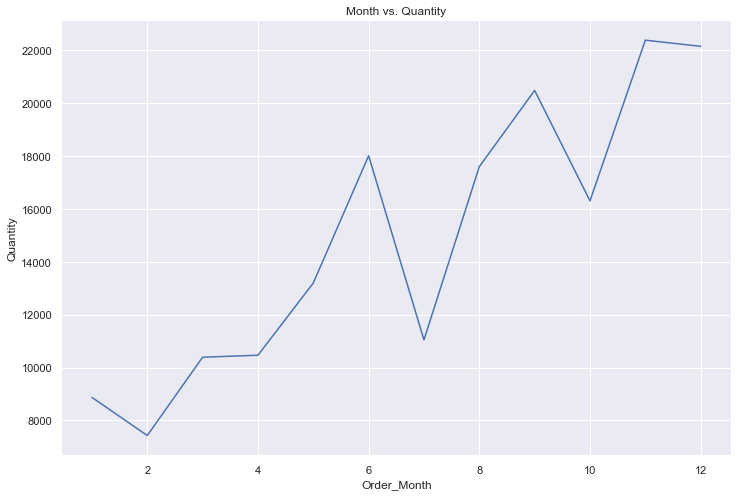

In [21]:
monthly = orders.groupby(by="Order_Month").agg({"Quantity":"sum"}).reset_index()
sns.set(rc={"figure.figsize":(12,8)})
sns.lineplot(x="Order_Month", y="Quantity", data=monthly).set_title("Month vs. Quantity");

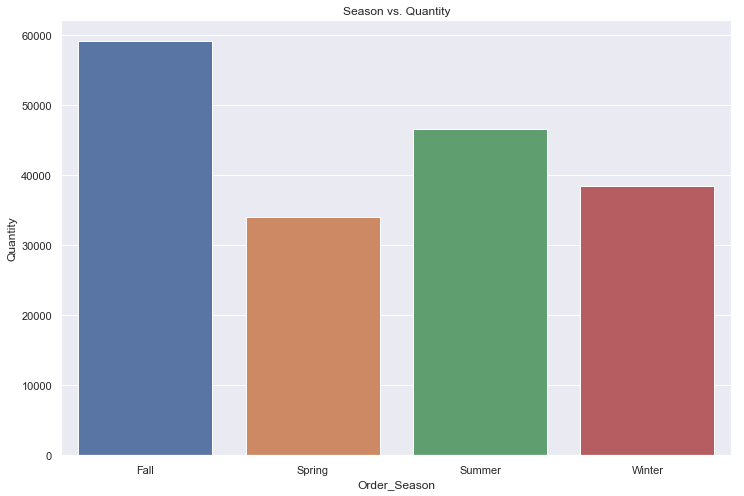

In [22]:
seasons = orders.groupby(by="Order_Season").agg({"Quantity":"sum"}).reset_index()
sns.barplot(x="Order_Season", y="Quantity", data=seasons).set_title("Season vs. Quantity");

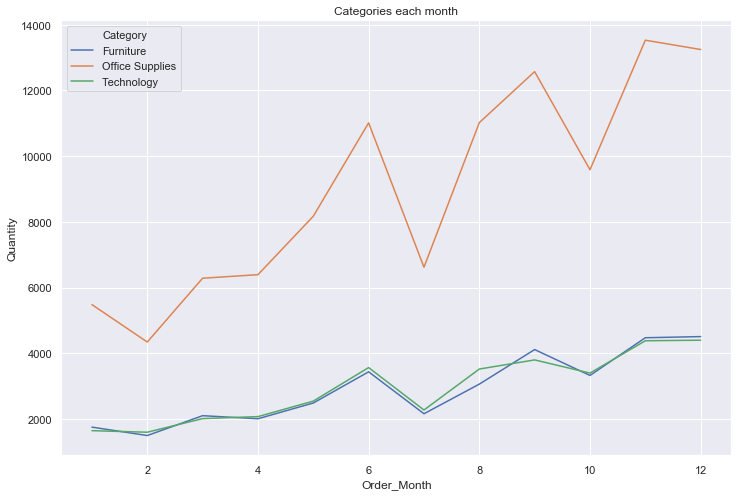

In [23]:
monthly_category = orders.groupby(by=["Order_Month", "Category"]).agg({"Quantity":"sum"}).reset_index()
sns.lineplot(x="Order_Month", y="Quantity", hue="Category", data=monthly_category).set_title("Categories each month");

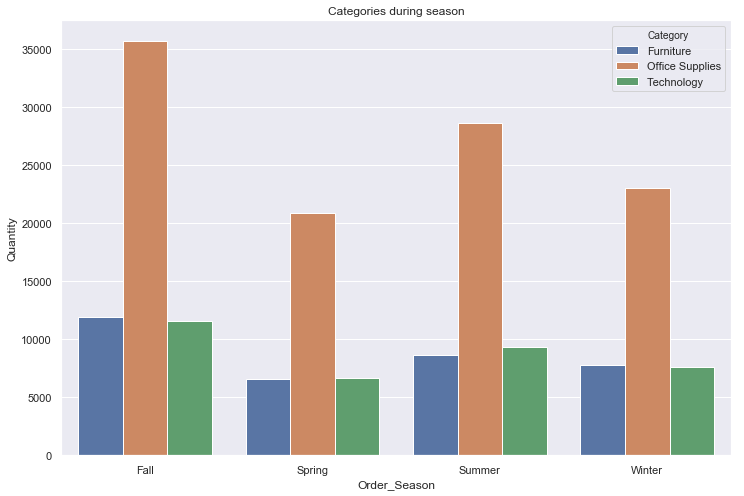

In [24]:
seasons_category = orders.groupby(by=["Order_Season", "Category"]).agg({"Quantity":"sum"}).reset_index()
sns.barplot(x="Order_Season", y="Quantity", hue="Category", data=seasons_category).set_title("Categories during season");

##### Seasonal Trend: 
1. It appears that the most popular season is fall and the least popular season is spring. 
2. Quantity of orders increment during Spring and Fall. 

### Problem 3: Why did customers make returns?
1. How much profit did we lose due to returns each year?
2. How many customer returned more than once? more than 5 times?
3. Which regions are more likely to return orders?
4. Which categories (sub-categories) of products are more likely to be returned?

In [37]:
print(returns.shape)
returns.head()

(1079, 3)


,Returned,Order_ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


In [39]:
returns.drop(labels="Region", axis=1, inplace=True)

In [43]:
returns = returns.merge(orders, how="left", left_on="Order_ID", right_on="Order_ID") 

In [44]:
shape_returns = returns.shape
print("New returns DataFrame has {r} rows and {c} columns".format(r=shape_returns[0], c=shape_returns[1]))

New returns DataFrame has 2220 rows and 27 columns


In [61]:
returns.insert(24, column="Profit_Abs", value=returns["Profit"].abs())

In [62]:
returns.head(3)

,Returned,Order_ID,Row_ID,Order_Date,Order_Year,Order_Month,Order_Season,Ship_Date,Ship_Mode,Customer_ID,...,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit_Abs,Profit,Shipping_Cost,Order_Priority
0,Yes,CA-2012-SA20830140-41210,31784,2012-10-28,2012,10,Fall,2012-10-30,First Class,SA-208301402,...,Technology,Phones,Apple iPhone 5S,2735.95,6,0.2,341.99,341.99,752.51,High
1,Yes,IN-2012-PB19210127-41259,30191,2012-12-16,2012,12,Winter,2012-12-19,First Class,PB-19210127,...,Furniture,Tables,"Lesro Conference Table, with Bottom Storage",1715.16,2,0.0,720.36,720.36,725.57,Critical
2,Yes,IN-2012-PB19210127-41259,30190,2012-12-16,2012,12,Winter,2012-12-19,First Class,PB-19210127,...,Furniture,Bookcases,"Safco Classic Bookcase, Pine",2197.50,5,0.0,153.75,153.75,627.27,Critical


** 1. How much profit did we lose due to returns each year? **

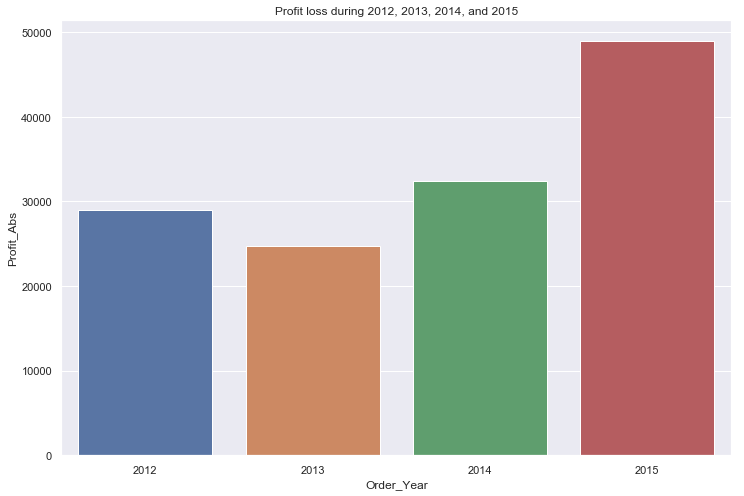

In [66]:
profit_loss = returns.groupby(by="Order_Year").agg({"Profit_Abs": "sum"}).reset_index()
sns.barplot(x="Order_Year", y="Profit_Abs", data=profit_loss).set_title("Profit loss during 2012, 2013, 2014, and 2015");

In [69]:
profit_loss

,Order_Year,Profit_Abs
0,2012,29022.34
1,2013,24695.95
2,2014,32389.49
3,2015,48928.17


##### Summary:
- In 2012 Profit loss equal to $29,022.34
 
- In 2013 Profit loss equal to $24,695.95
 
- In 2014 Profit loss equal to $32,389.49
 
- In 2015 Profit loss equal to $48,928.17
 
- 2015 has the highest profit loss

** 2. How many customer returned more than once? more than 5 times? **

In [93]:
return_customer = returns.groupby(by="Customer_ID").agg({"Customer_ID":"count"}).rename(columns={"Customer_ID":"Count"}).reset_index()

In [102]:
mask = return_customer["Count"] > 1
print("{} Customers returned item more than once".format(len(return_customer[mask])))

547 Customers returned item more than once


In [103]:
mask2 = return_customer["Count"] > 5
print("{} Customers returned item more than 5 times".format(len(return_customer[mask2])))

46 Customers returned item more than 5 times


** 3. Which regions are more likely to return orders? **

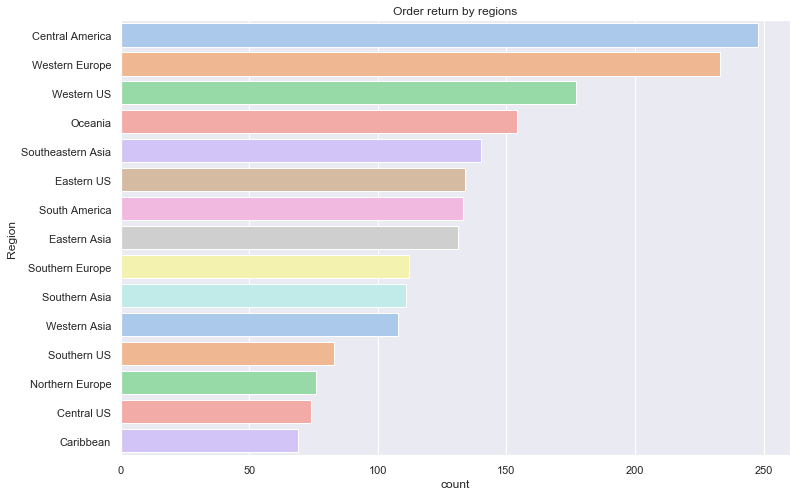

In [106]:
sns.countplot(y="Region", palette="pastel",data=returns
             , order=returns["Region"].value_counts().iloc[:15]
              .index).set_title("Order return by regions");

 - Central America, Wastern Europe, and Western US regions are more likely to return items than other regions

** 4. Which categories (sub-categories) of products are more likely to be returned? **

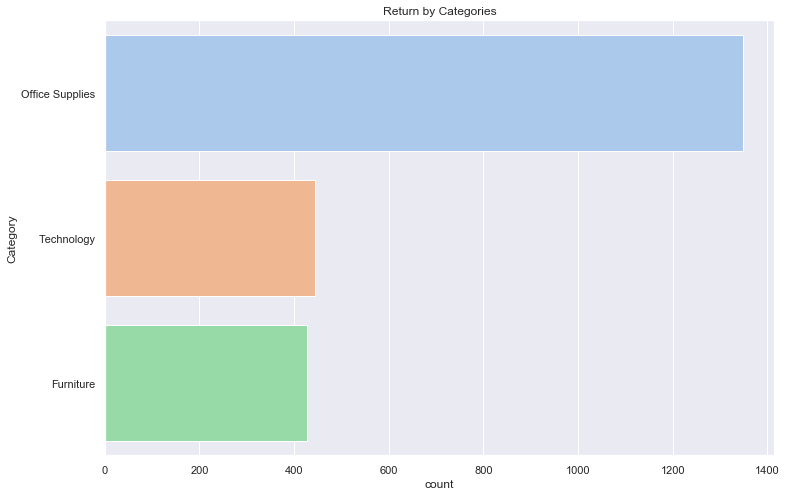

In [112]:
sns.countplot(y="Category", palette="pastel", data=returns
             , order=returns["Category"].value_counts().index).set_title("Return by Categories");

- Office Supplies are more likely to be returned than Technology and Furniture

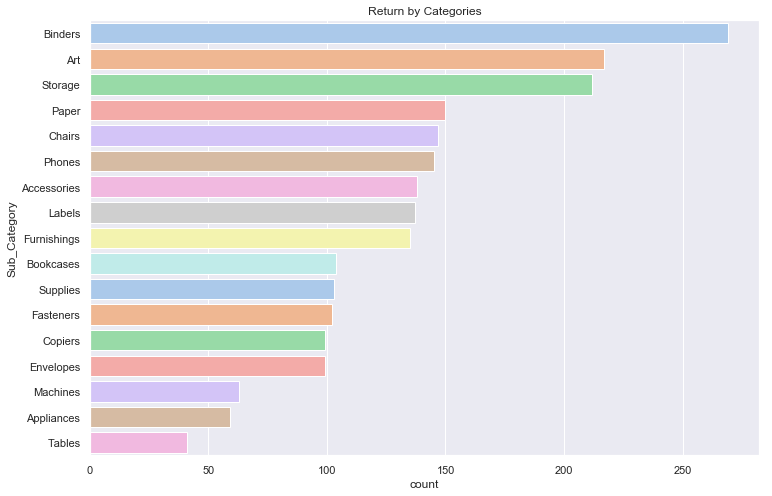

In [113]:
sns.countplot(y="Sub_Category", palette="pastel", data=returns
             , order=returns["Sub_Category"].value_counts().index).set_title("Return by Categories");

- Binders, Art, and Storages are top three sub categories that returned 

# Part II: Machine Learning and Business Use Case
- Now your manager has a basic understanding of why customers returned orders. Next, he wants you to use machine learning to predict which orders are most likely to be returned. In this part, you will generate several features based on our previous findings and your manager's requirements.

### Problem 4: Feature Engineering
#### Step 1: Create the dependent variable

In [120]:
print("True is equal to number of returned item")
orders["Order_ID"].isin(returns["Order_ID"]).value_counts().to_frame()

True is equal to number of returned item


,Order_ID
False,49070
True,2220


In [125]:
orders["Returned"] = orders["Order_ID"].isin(returns["Order_ID"])

In [127]:
def one_zero(boolean):
    if boolean == True:
        return(1)
    else:
        return(0)

In [130]:
orders["Returned"] = orders["Returned"].apply(one_zero)

In [147]:
orders.sample(3)

,Row_ID,Order_ID,Order_Date,Order_Year,Order_Month,Order_Season,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,...,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Returned
26980,4937,MX-2014-BE1145531-41650,2014-01-11,2014,1,Winter,2014-01-15,Standard Class,BE-1145531,Brad Eason,...,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",101.04,6,0.00,43.44,7.00,Medium,1
26755,27828,ID-2013-BN11470130-41633,2013-12-25,2013,12,Winter,2013-12-28,Second Class,BN-11470130,Brad Norvell,...,Office Supplies,Envelopes,"GlobeWeis Interoffice Envelope, Recycled",74.13,3,0.47,-21.00,7.13,Medium,0
15637,3865,MX-2014-CS1250582-41917,2014-10-05,2014,10,Fall,2014-10-10,Standard Class,CS-1250582,Cindy Stewart,...,Furniture,Furnishings,"Eldon Frame, Erganomic",321.64,7,0.40,-176.90,18.57,Medium,0


#### Step 2:
- Your manager believes that **how long it took the order to ship** would affect whether the customer would return it or not. 
- He wants you to generate a feature which can measure how long it takes the company to process each order.

In [152]:
orders.insert(6, column="Process_Time", value=orders["Ship_Date"].dt.dayofyear - orders["Order_Date"].dt.dayofyear)

In [154]:
orders.head(3)

,Row_ID,Order_ID,Order_Date,Order_Year,Order_Month,Order_Season,Process_Time,Ship_Date,Ship_Mode,Customer_ID,...,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Returned
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014,11,Fall,2,2014-11-13,First Class,AB-100151402,...,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014,2,Winter,2,2014-02-07,Second Class,JR-162107,...,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,0
2,25330,IN-2014-CR127307-41929,2014-10-17,2014,10,Fall,1,2014-10-18,First Class,CR-127307,...,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,0


#### Step 3:

- If a product has been returned before, it may be returned again. 
- Let us generate a feature indictes how many times the product has been returned before.
- If it never got returned, we just impute using 0.

In [166]:
return_item = returns.groupby(by="Product_ID").agg({"Product_ID":"count"}).rename(columns={"Product_ID":"Returned_Count"}).reset_index()

In [168]:
return_item.head(3)

,Product_ID,Returned_Count
0,FUR-BO-3176,1
1,FUR-BO-3615,1
2,FUR-BO-3616,1


In [179]:
orders = orders.merge(return_item, how="left", on="Product_ID")

In [185]:
orders["Returned_Count"] = orders["Returned_Count"].fillna(value=0).astype("int")

In [210]:
orders.head(3)

,Row_ID,Order_ID,Order_Date,Order_Year,Order_Month,Order_Season,Process_Time,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,City,State,Country,Region,Market,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority,Returned,Returned_Count
0,40098,CA-2014-AB10015140-41954,2014-11-11,2014,11,Fall,2,2014-11-13,First Class,AB-100151402,Aaron Bergman,Consumer,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High,0,0
1,26341,IN-2014-JR162107-41675,2014-02-05,2014,2,Winter,2,2014-02-07,Second Class,JR-162107,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical,0,2
2,25330,IN-2014-CR127307-41929,2014-10-17,2014,10,Fall,1,2014-10-18,First Class,CR-127307,Craig Reiter,Consumer,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium,0,2


### Problem 5: Fitting Models
- You can use any binary classification method you have learned so far.
- Use 80/20 training and test splits to build your model. 
- Double check the column types before you fit the model.
- Only include useful features. i.e all the `ID`s should be excluded from your training set.
- Not that there are only less than 5% of the orders have been returned, so you should consider using the `createDataPartition` function from `caret` package that does a **stratified** random split of the data. Scikit-learn also has a [StratifiedKfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn-model-selection-stratifiedkfold) function that does similar thing.
- Do forget to `set.seed()` before the spilt to make your result reproducible.

In [212]:
columns = ["Category", "Sub_Category", "Region", "Ship_Mode", "Segment", "Order_Priority", "Order_Month",
          "Sales", "Profit", "Quantity", "Discount", "Shipping_Cost", "Process_Time", "Returned_Count", "Order_Season"]

In [213]:
X = pd.get_dummies(orders[columns], drop_first=True, dummy_na=True)
y = orders['Returned']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

##### Logistic regression

In [219]:
Logi_Regr = LogisticRegression(class_weight='balanced')
Logi_Regr.fit(X_train, y_train)
y_predict = Logi_Regr.predict(X_test)

In [221]:
confusion_matrix(y_test, y_predict)

array([[7229, 2585],
       [ 151,  293]], dtype=int64)

In [222]:
roc_auc_score(y_test, y_predict)

0.6982553421569113

##### Random forest

In [224]:
ran_for = RandomForestClassifier(n_estimators=1000, max_depth=9, class_weight='balanced', n_jobs=-1)
ran_for.fit(X_train, y_train)
y_predict = ran_for.predict(X_test)

In [225]:
confusion_matrix(y_test, y_predict)

array([[5013, 4801],
       [  42,  402]], dtype=int64)

In [226]:
roc_auc_score(y_test, y_predict)

0.7081031510418101